### Import dependencies

In [1]:
import pandas as pd
import numpy as np

from cmdstanpy import CmdStanModel
import arviz as az

import matplotlib.pyplot as plt

### Import dataset

In [16]:
with open("data/Fecondità.csv", "rb") as f:
    dataset=pd.read_csv(f)

dataset = dataset.sort_values(by=['Territorio', 'TIME']) # the proximity matrix is built with the prov in alphabetic order

I = 106
T = 10

dataset

,Territorio,TIME,età.media.delle.madri.al.parto,età.media.dei.padri.alla.nascita.del.figlio,tasso.di.fecondità.totale,tasso.di.inattività.dei.maschi,tasso.di.inattività.delle.femmine,tasso.di.inattività.totale,tasso.di.occupazione.dei.maschi,tasso.di.occupazione.delle.femmine,tasso.di.occupazione.totale
930,Agrigento,2011,30.94,34.80,1.37,42.911800,75.561168,59.924924,47.392418,19.828757,33.029603
931,Agrigento,2012,30.73,34.57,1.35,43.934839,74.366121,59.780301,45.282895,20.513632,32.385627
932,Agrigento,2013,31.09,34.78,1.27,46.361107,73.567265,60.518499,43.469198,19.889053,31.198656
933,Agrigento,2014,30.99,35.06,1.33,47.098738,72.427712,60.272133,39.673492,20.296449,29.595648
934,Agrigento,2015,31.14,34.97,1.27,45.169256,75.916130,61.148536,40.057236,18.153835,28.674135
...,...,...,...,...,...,...,...,...,...,...,...
625,Viterbo,2016,31.99,35.76,1.23,39.518267,60.635768,50.408778,52.769263,32.263986,42.194134
626,Viterbo,2017,32.17,35.73,1.16,41.158020,61.241767,51.511845,51.680541,33.283508,42.195912
627,Viterbo,2018,32.05,35.64,1.20,42.945825,61.820030,52.659989,50.508888,33.458828,41.733539
628,Viterbo,2019,31.97,35.51,1.11,44.935350,63.118101,54.287825,49.777042,32.974065,41.133933


### Import computed clusters

In [18]:
with open("true_dataset_s_binder.csv", "rb") as f:
    s_binder=pd.read_csv(f)
s_fixed= np.array(s_binder['V1'])

n_clusters = np.max(s_fixed)
print(n_clusters)

6


### Get response

0.015125712353150588
1.3187169811320756
(106, 10)


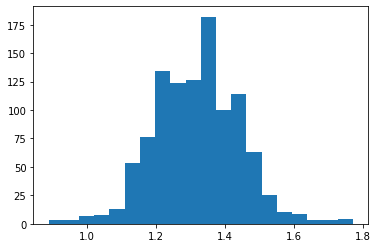

In [19]:
Y=np.array(dataset["tasso.di.fecondità.totale"])

print(np.var(Y))
print(np.mean(Y))


y = []
y_tmp = np.zeros(10)
for prov in np.unique(dataset["Territorio"]):
    data_prov = dataset[dataset["Territorio"] == prov]
    y_tmp = np.array(data_prov["tasso.di.fecondità.totale"])
    y.append(y_tmp)
y = np.array(y)
# print(y)
print(y.shape)
plt.hist(Y,bins=20)    
plt.show()

### Get covariates

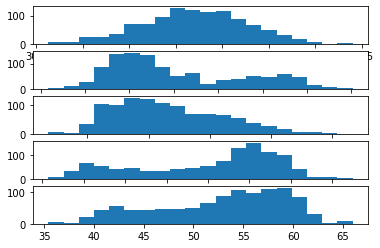

In [20]:
P = 5 # number of covariates
X_list = []

X_list.append(np.array(dataset["età.media.delle.madri.al.parto"]))
# X_list.append(np.array(dataset["età.media.dei.padri.alla.nascita.del.figlio"]))
X_list.append(np.array(dataset["tasso.di.inattività.delle.femmine"]))
X_list.append(np.array(dataset["tasso.di.inattività.dei.maschi"]))
# X_list.append(np.array(dataset["tasso.di.inattività.totale"]))
X_list.append(np.array(dataset["tasso.di.occupazione.delle.femmine"]))
X_list.append(np.array(dataset["tasso.di.occupazione.dei.maschi"]))
# X_list.append(np.array(dataset["tasso.di.occupazione.totale"]))

fig, axs = plt.subplots(P)

for i in range(P):
    axs[i].hist(X_list[i],bins=20)

plt.show()

### Standardization of X and y

In [21]:
for i in range(P):
    X_list[i] = (X_list[i]-np.mean(X_list[i])) / np.sqrt(np.var(X_list[i]))


y= (y-np.mean(y))/np.sqrt(np.var(y))

### Create the matrix of covariates

In [22]:
X=np.ones((1060,P+1))

for i in range(P):
    X[:,i+1] = X_list[i]

X_r = np.reshape(X,(106,10,P+1))

X_r.shape

(106, 10, 6)

### Compute the covariance matrix of the random effects

In [23]:
with open("data/Proximity_matrix.csv", "rb") as f:
    W_raw=pd.read_csv(f)
    
W_raw=np.matrix(W_raw)

for i in range(I):
    W_raw[i,i] = 0

W_raw=np.matrix(W_raw)
Wt = W_raw.transpose()
(Wt == W_raw).all()

# compute Qinv
one_vector = np.ones(shape = (I,1))
B = np.matmul(W_raw , one_vector)  
A =  np.diagflat(np.array(B))
W_intermedia = A - W_raw


rho = 0.95
Q = rho * W_intermedia  + (1-rho) * np.eye(I)
Qinv = np.linalg.inv(Q)
# Qinv.shape
W_intermedia.shape

#Qinv must be positive definite
for i in range(I):
    for j in range(I):
        Qinv[j,i] = Qinv[i,j]

Qinv=np.matrix(Qinv)
Qinvt = Qinv.transpose()
print((Qinv == Qinvt).all())

True


### Stan model

In [9]:
beta_clus_stan = """
data
{
    int I; // number of areal locations
    int T; // number of time steps
    int P; // number of covariates
    int N; // number of clusters
    
    array[I] vector[T] y; // value of interest
    array[I] matrix[T,P+1] X; // covariates matrices for each province
      
    // hyperpar vector of regressors
    vector[P+1] mu_0_mean;
    real        mu_0_var;
    real        a_sigma2_0;
    real        b_sigma2_0;
    
    // mean of w_1 (random effect for every province at time 1)
    vector[I] mu_w_1;
    
    // alpha
    real a_alpha;
    real b_alpha;
    
    // tau^2
    real a_tau2;
    real b_tau2;
    
    // sigma^2
    real a_sigma2;
    real b_sigma2;
    
    // rho 
    real rho;
    
    //xis
    real mu_xi;
    real sigma2_xi;

    // Qinv
    matrix[I,I] inv_Q;
    
    // s
    array[I] int s;
}

transformed data {
    matrix[I, I] L;
    L = cholesky_decompose(inv_Q);
    
    real sigma_xi = sqrt(sigma2_xi);
    real mu_0_sd = sqrt(mu_0_var);
    
}

parameters
{
    real<lower=0> sigma2; 
    real<lower=0> tau2;
    vector[P+1] mu_0;
    real<lower=0> sigma2_0;
    
    // autoregressive coefficient
    real xi;
    
    // betas for the mixture of the dirichlet process
    array[N] vector[P+1] betas;
    
    // for the random effect construction 
    array[T] vector[I] w_raw;
}

transformed parameters
{   
    
    // random effects tmp
    matrix[I,T]                ws_tmp;
    
    ws_tmp[1:I,1] =  mu_w_1 + L*w_raw[1];
    
    for (t in 2:T)
        ws_tmp[1:I,t] = ws_tmp[1:I,t-1]*xi + L*w_raw[t]; 
    
    matrix[T,I]   ws = (ws_tmp)'; //otherwise I have to transpose in the for loop at each iteration
    
    // stan wants std
    real sigma = sqrt(sigma2);
    real tau = sqrt(tau2);
    real sigma_0 = sqrt(sigma2_0);

}

model
{
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    sigma2_0 ~ inv_gamma(a_sigma2_0, b_sigma2_0);
    mu_0 ~ normal(mu_0_mean, mu_0_sd);
    
    for (t in 1:T) 
        w_raw[t] ~ normal(0, tau); 
        
    xi ~ normal(mu_xi,sigma_xi);
    
    for (n in 1:N)
        betas[n] ~ normal(mu_0, sigma_0);
    
    for (i in 1:I) {
        int clus_i=s[i];
        y[i] ~ normal(X[i]*betas[clus_i] + ws[1:T,i], sigma);
    }
}

generated quantities 
{   
    // log likelihood for each areal location 
    vector[I] log_lik;
    
    for (i in 1:I) {
        int clus_i = s[i];
        log_lik[i] = normal_lpdf(y[i] | X[i]*betas[clus_i] + ws[1:T,i], sigma);
    }
    
        
}
"""

stan_file = "stan_files/model_clus.stan"

with open(stan_file, "w") as fp:
    fp.write(beta_clus_stan)
    
model_clus = CmdStanModel(stan_file=stan_file)

14:30:39 - cmdstanpy - INFO - compiling stan file /home/riccardo/bayesian-project/stan_files/model_clus.stan to exe file /home/riccardo/bayesian-project/stan_files/model_clus
14:35:33 - cmdstanpy - INFO - compiled model executable: /home/riccardo/bayesian-project/stan_files/model_clus


### Hyperparameters

In [24]:
H = 10
mu_0_mean = np.zeros(P+1)
mu_0_var = 9
a_sigma2_0 = 3
b_sigma2_0 = 2
mu_w_1 = np.zeros(I)
a_alpha = 3
b_alpha = 3
a_tau2 = 3
b_tau2 = 0.5
a_sigma2 = 3
b_sigma2 = 1
rho = 0.95
mu_xi = 0
sigma2_xi = 4
s= s_fixed.astype(int)

data_clus = {
    "I": I,
    "T": T,
    "P": P,
    "N": n_clusters,
    "y": y,
    "X": X_r,
    "mu_0_mean": mu_0_mean,
    "mu_0_var": mu_0_var,
    "a_sigma2_0": a_sigma2_0,
    "b_sigma2_0": b_sigma2_0,
    "mu_w_1": mu_w_1,
    "a_alpha": a_alpha,
    "b_alpha": b_alpha,
    "a_tau2": a_tau2,
    "b_tau2": b_tau2,
    "a_sigma2": a_sigma2,
    "b_sigma2": b_sigma2,
    "rho": rho,
    "mu_xi": mu_xi,
    "sigma2_xi": sigma2_xi,
    "inv_Q": Qinv,
    "s": s
}

### Sampling phase

In [25]:
fit_clus = model_clus.sample(data_clus
                    , iter_warmup = 10000
                    , iter_sampling = 10000
#                     , adapt_delta=0.9
#                     , step_size = 1.5
#                     , max_treedepth = 10
#                     , show_console = True
                   )

15:17:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:32:03 - cmdstanpy - INFO - CmdStan done processing.
15:32:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/riccardo/bayesian-project/stan_files/model_clus.stan', line 106, column 8 to column 41)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/riccardo/bayesian-project/stan_files/model_clus.stan', line 101, column 8 to column 34)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/riccardo/bayesian-project/stan_files/model_clus.stan', line 110, column 8 to column 61)
Consider re-running with show_console=True if the above output is unclear!


### Posterior inference

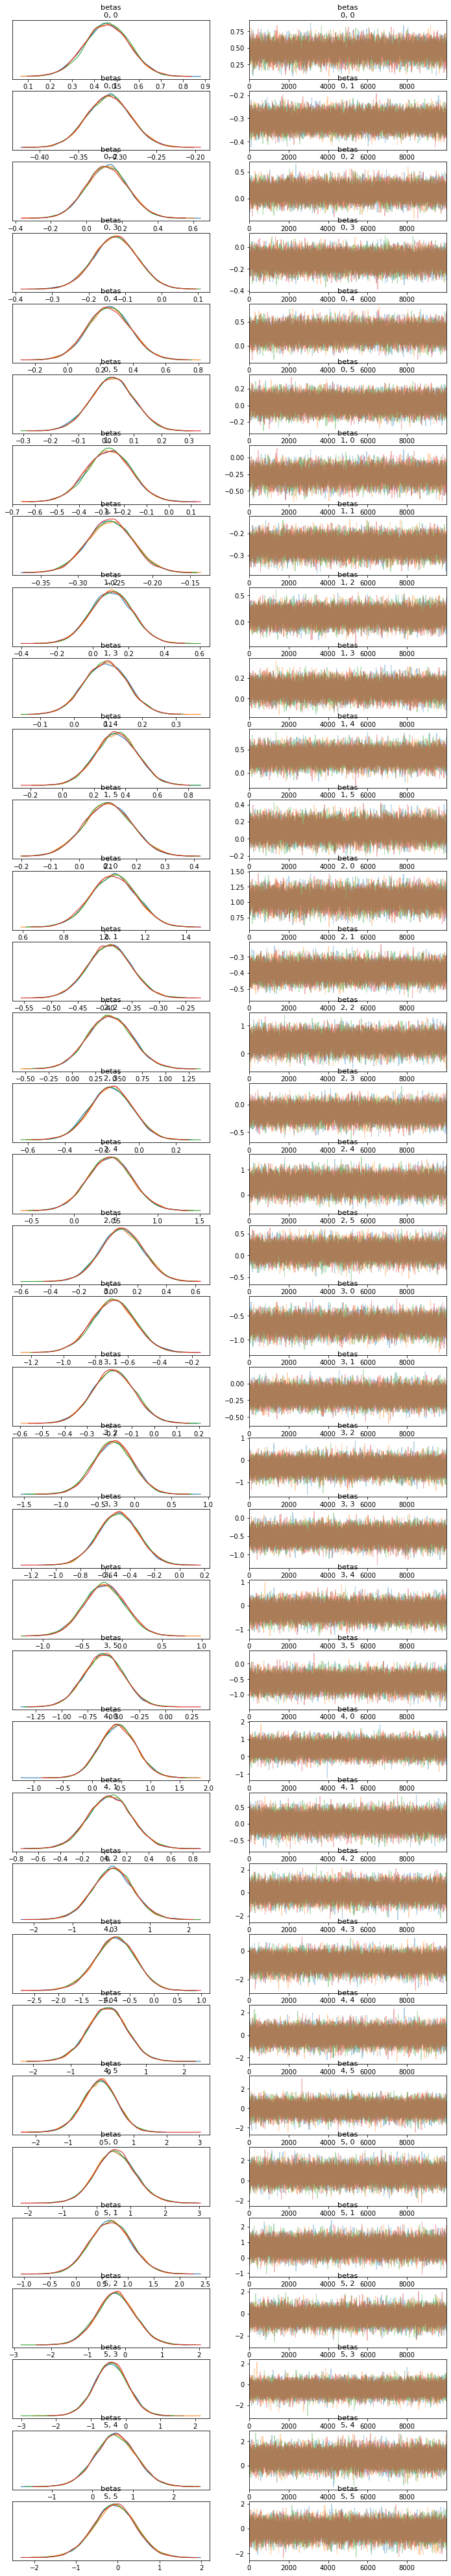

In [27]:
fit_clus_az = az.from_cmdstanpy(fit_clus)

az.rcParams["plot.max_subplots"] = 100

az.plot_trace(fit_clus_az,var_names=["betas"],
              compact = False
             )
plt.show()

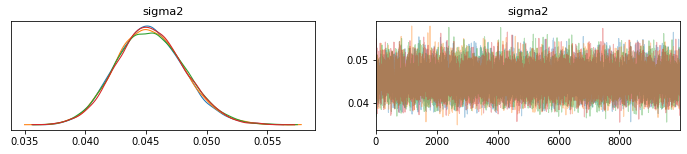

In [30]:
az.plot_trace(fit_clus_az,var_names=["sigma2"],
              compact = False
             )
plt.show()

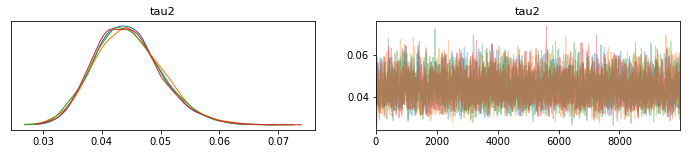

In [31]:
az.plot_trace(fit_clus_az,var_names=["tau2"],
              compact = False
             )
plt.show()

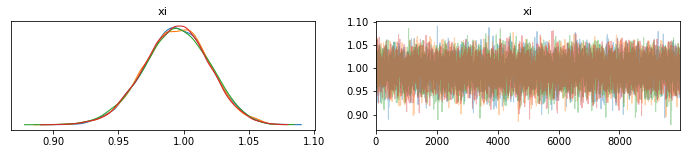

In [32]:
az.plot_trace(fit_clus_az,var_names=["xi"],
              compact = False
             )
plt.show()

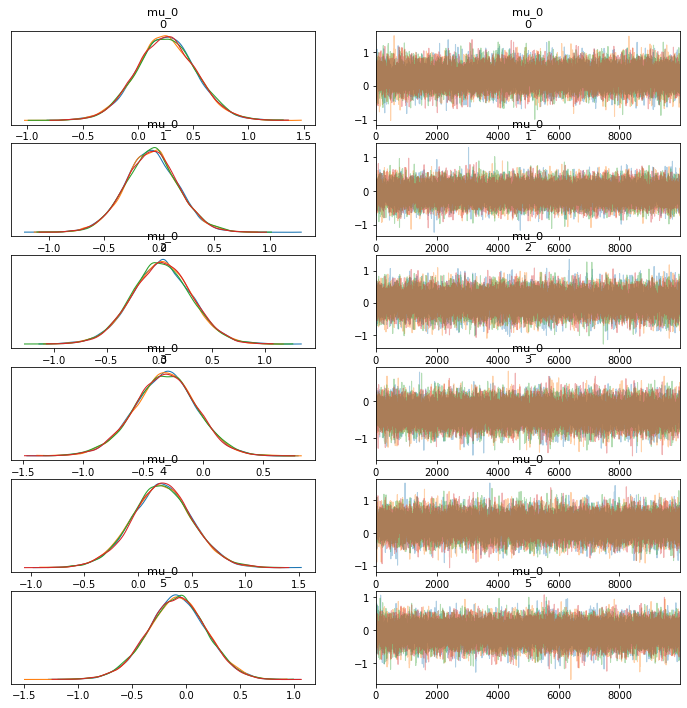

In [33]:
az.plot_trace(fit_clus_az,var_names=["mu_0"],
              compact = False
             )
plt.show()

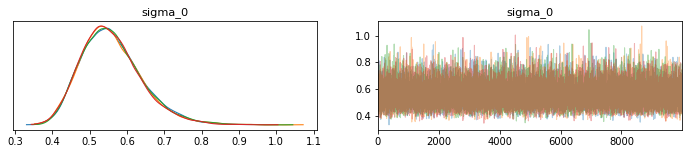

In [35]:
az.plot_trace(fit_clus_az,var_names=["sigma_0"],
              compact = False
             )
plt.show()

### Computation of WAIC

In [28]:
az.waic(fit_clus, scale="deviance")

/home/riccardo/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1644: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 40000 posterior samples and 106 observations log-likelihood matrix.

              Estimate       SE
deviance_waic     4.23    57.67
p_waic          252.71        -

There has been a warning during the calculation. Please check the results.

### Computation of LOO

In [29]:
az.loo(fit_clus)

/home/riccardo/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1036: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/riccardo/.local/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 40000 posterior samples and 106 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -62.98    30.54
p_loo      313.58        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          1    0.9%
   (0.7, 1]   (bad)        82   77.4%
   (1, Inf)   (very bad)   23   21.7%

### Save means of betas

In [16]:
betas = fit_clus.betas
betas.shape
beta_means = np.zeros((P+1,n_clusters))

for c in range(P+1):
    for j in range(n_clusters):
        beta_means[c,j] = np.mean(betas[:,j,c])
        
        
np.savetxt("outputs/beta_means.txt",beta_means)
beta_means

array([[ 0.45379438, -0.27245982,  1.05463735, -0.67860091,  0.43954842,
         0.54834815],
       [-0.3301912 , -0.26163503, -0.42570546, -0.18764513,  0.0469079 ,
         0.66327268],
       [ 0.1396039 ,  0.10127779,  0.35212002, -0.30397419,  0.03229202,
        -0.28589431],
       [-0.12683835,  0.09509373, -0.13607308, -0.49398562, -0.79809134,
        -0.40952418],
       [ 0.26432208,  0.3272925 ,  0.37537785, -0.23970637, -0.05339772,
         0.54443695],
       [ 0.05221696,  0.11271391,  0.14685521, -0.58964541, -0.03226062,
        -0.06942346]])

### Save betas divided into clusters

In [17]:
for j in range(n_clusters):
    filename = "outputs/betas_cluster_"+str(j+1)+".csv"
    header = ["intercetta","età_madri","inatt_donne","inatt_uomini","occup_donne","occup_uomini"]
    df = pd.DataFrame(betas[:,j,:])
    df.to_csv(filename, header=header)

### Save random effects

In [18]:
ws = np.zeros((I,T))

for i in range(I):
    for t in range(T):
        ws[i,t] = np.mean(fit_clus.ws[:,t,i])

filename = "outputs/ws.csv"
df = pd.DataFrame(ws)
df.to_csv(filename)